In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from data_utils import get_id_type_list_from_annotations
from image_utils import get_image_data

In [4]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print("Number of hand-made annotations: ", len(annotations))

trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix', 'ok'])
bad_id_type_list = get_id_type_list_from_annotations(annotations, select=['to_remove', ])
print(len(trainval_id_type_list), len(bad_id_type_list))

## Remove green imagery
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)
print(len(trainval_id_type_list))

Number of hand-made annotations:  4483
2839 1644
2821


In [5]:
import numpy as np
from data_utils import compute_type_distribution
compute_type_distribution(np.array(trainval_id_type_list))

[0.32825239276852181, 0.33002481389578164, 0.34172279333569655]

In [6]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
    cache = DataCache(0)

In [7]:
# os.environ['KERAS_BACKEND']='tensorflow'

from custom_squeezenet import get_cnn

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [8]:
cnn = get_cnn()
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1_1 (InputLayer)           (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
input_2_2 (InputLayer)           (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 149, 149, 64)  1792                                         
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 149, 149, 64)  1792                                         
___________________________________________________________________________________________

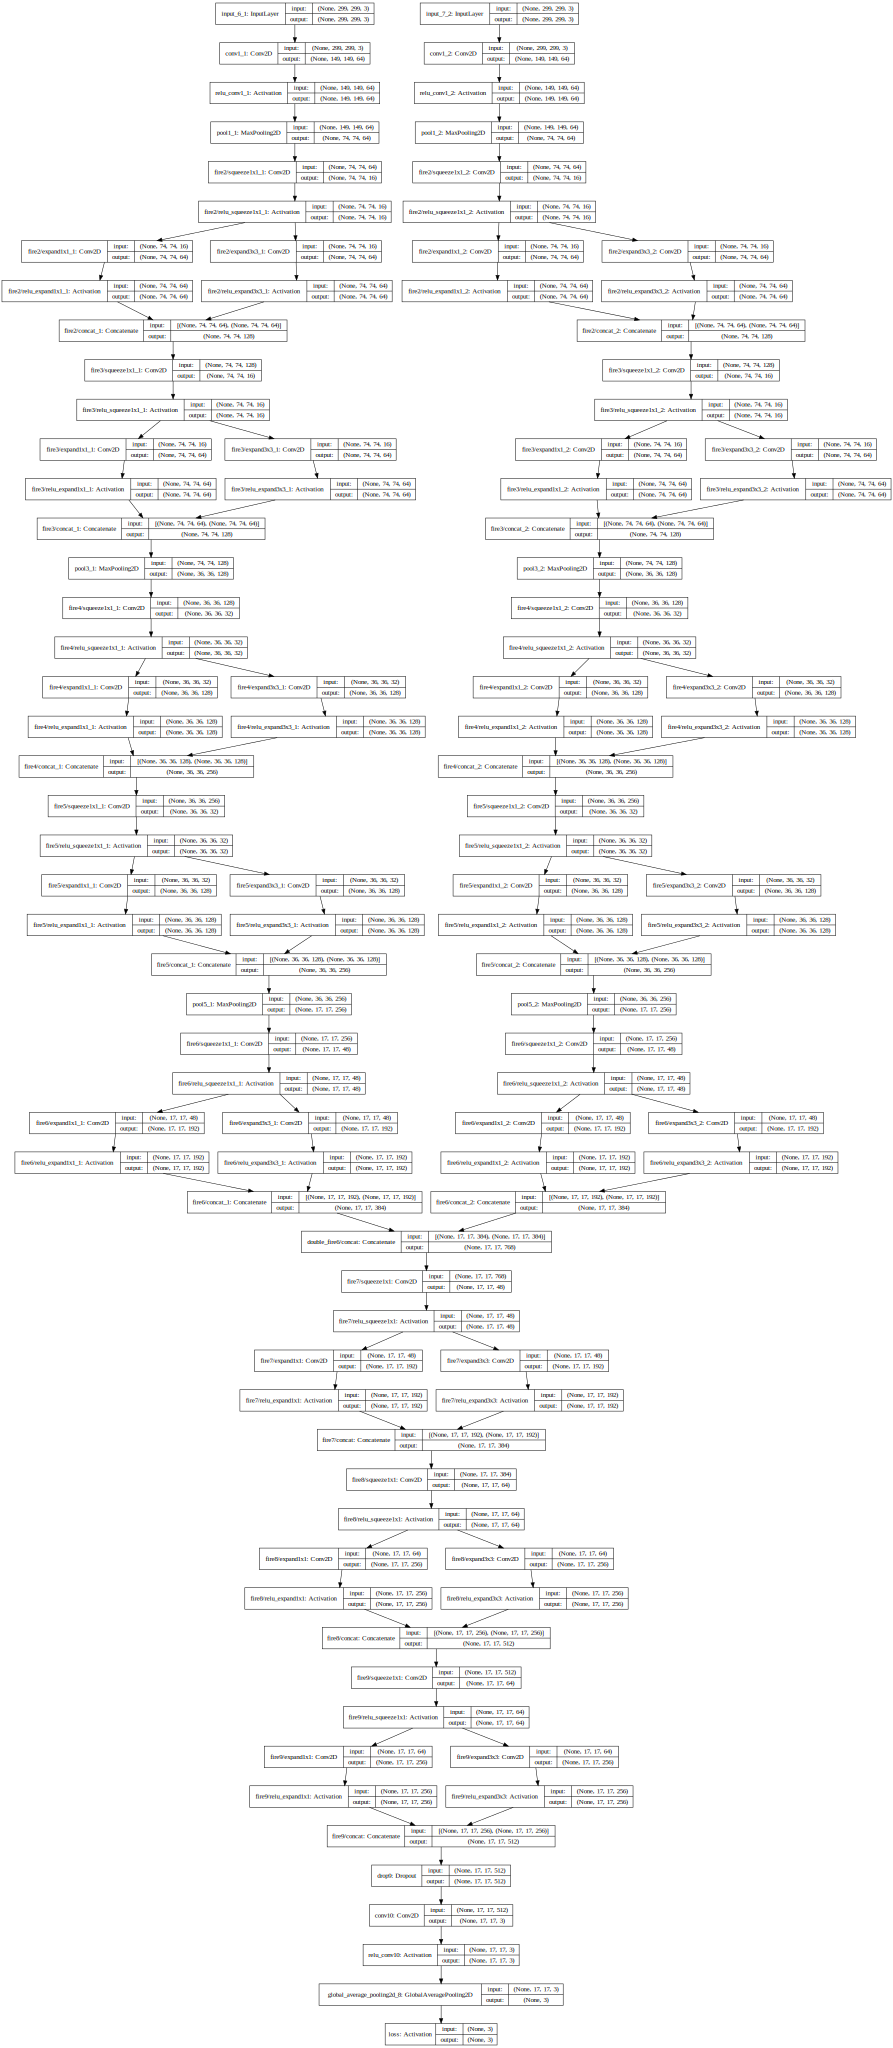

In [12]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
# ####################################################
#  Setup NN parameters
# ####################################################
from cv_utils import generate_trainval_kfolds
from data_utils import to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import find_best_weights_file2

seed = 54321
optimizer = 'adadelta'
input_shape = (3, 299, 299)

nb_epochs = 30
batch_size = 8
lr_base = 0.1

load_best_weights = True


# ####################################################
#  Start CV
# ####################################################
from training_utils import exp_decay, step_decay

n_folds = 6
val_fold_index = 0
val_fold_indices = []

for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    save_prefix = 'cnn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
    cnn = get_cnn(optimizer=optimizer, lr=lr_base)

    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename)

    # lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7)
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=0.977)
    # lrate_decay_f = None
    
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn,
              train_id_type_list,
              val_id_type_list,
              option='cervix/os', 
              normalize_data=True,
              normalization='vgg',
              nb_epochs=nb_epochs,
              samples_per_epoch=2.0* len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              image_size=input_shape[1:][::-1],
              seed=seed,              
              save_prefix=save_prefix)
    if h is None:
        continue




 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-24 19:13:43.131648 - Get custom squeezenet model ...

 2017-05-24 19:13:47.940279 - Start training ...

-- Training parameters: 8, 30, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
597/597 [==============================] - 2755s - loss: 1.0882 - acc: 0.4183 - precision: 0.2718 - recall: 0.0718 - val_loss: 1.0563 - val_acc: 0.5246 - val_precision: 0.1475 - val_recall: 0.0225
Epoch 2/30
597/597 [==============================] - 429s - loss: 1.0295 - acc: 0.4864 - precision: 0.5664 - recall: 0.1838 - val_loss: 0.9834 - val_acc: 0.5102 - val_precision: 0.6322 - val_recall: 0.2951
Epoch 3/30
597/597 [==============================] - 431s - loss: 0.9958 - acc: 0.5105 - precision: 0.5909 - recall: 0.2494 - val_loss: 0.9590 - val_acc: 0.5328 - v

In [ ]:
## Cross-validation:

val_fold_index = 0
cv_mean_loss = 0
for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):
    
    save_prefix = 'cnn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
    cnn = get_cnn(optimizer=optimizer, lr=lr_base)

    weights_files = glob("weights/%s*.h5" % save_prefix)
    assert len(weights_files) > 0, "Failed to load weights"
    best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
    print("Load best loss weights: ", best_weights_filename, best_val_loss)
    cnn.load_weights(best_weights_filename)

    loss = validate(cnn, 
                     val_id_type_list, 
                     option='cervix/os',
                     normalize_data=True,
                     normalization='vgg',
                     image_size=input_shape[1:][::-1],
                     save_prefix=save_prefix,
                     batch_size=8,
                     seed=seed,
                     xy_provider_cache=cache)    
    cv_mean_loss += loss
    
cv_mean_loss *= 1.0 / n_folds



 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-25 20:01:46.923943 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_26_val_loss=0.8327_val_acc=0.6352_val_precision=0.6709_val_recall=0.5246.h5 0.8327
Image normalization:  vgg
Image normalization:  vgg
-- 8 batch loss :  0.887638  | info: [('6782', 'AType_1') ('470', 'Type_1') ('976', 'AType_1')
 ('4849', 'AType_3') ('3044', 'AType_1') ('911', 'Type_2')
 ('3000', 'AType_1') ('1402', 'AType_1')]
-- 16 batch loss :  0.836104  | info: [('6836', 'AType_3') ('2985', 'AType_3') ('1076', 'AType_3')
 ('6283', 'AType_3') ('331', 'AType_2') ('1637', 'AType_3')
 ('791', 'Type_1') ('1289', 'Type_1')]
-- 24 batch loss :  0.887253  | info: [('6447', 'AType_1') ('5611', 'AType_3') ('1021', 'AType_3')
 ('3312', 'AType_3') ('1333', 'AType_1') ('5868'

In [ ]:
## Predict on test data

## Logs

```
seed = 54321
optimizer = 'adadelta'
input_shape = (3, 299, 299)

nb_epochs = 30
batch_size = 8
lr_base = 0.1

load_best_weights = True


---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-24 19:13:43.131648 - Get custom squeezenet model ...

 2017-05-24 19:13:47.940279 - Start training ...

-- Training parameters: 8, 30, 4776, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
597/597 [] - 2755s - loss: 1.0882 - acc: 0.4183 - precision: 0.2718 - recall: 0.0718 - val_loss: 1.0563 - val_acc: 0.5246 - val_precision: 0.1475 - val_recall: 0.0225
Epoch 2/30
597/597 [] - 429s - loss: 1.0295 - acc: 0.4864 - precision: 0.5664 - recall: 0.1838 - val_loss: 0.9834 - val_acc: 0.5102 - val_precision: 0.6322 - val_recall: 0.2951
Epoch 3/30
597/597 [] - 431s - loss: 0.9958 - acc: 0.5105 - precision: 0.5909 - recall: 0.2494 - val_loss: 0.9590 - val_acc: 0.5328 - val_precision: 0.5924 - val_recall: 0.2971
Epoch 4/30
597/597 [] - 425s - loss: 0.9777 - acc: 0.5218 - precision: 0.6235 - recall: 0.2898 - val_loss: 1.0110 - val_acc: 0.5369 - val_precision: 0.5970 - val_recall: 0.3115
Epoch 5/30
597/597 [] - 424s - loss: 0.9652 - acc: 0.5381 - precision: 0.6199 - recall: 0.3197 - val_loss: 0.9263 - val_acc: 0.5656 - val_precision: 0.6422 - val_recall: 0.3832
Epoch 6/30
597/597 [] - 423s - loss: 0.9590 - acc: 0.5396 - precision: 0.6279 - recall: 0.3204 - val_loss: 0.9192 - val_acc: 0.5697 - val_precision: 0.6809 - val_recall: 0.3320
Epoch 7/30
597/597 [] - 423s - loss: 0.9425 - acc: 0.5523 - precision: 0.6244 - recall: 0.3536 - val_loss: 0.9358 - val_acc: 0.5615 - val_precision: 0.6601 - val_recall: 0.3402
Epoch 8/30
597/597 [] - 430s - loss: 0.9383 - acc: 0.5572 - precision: 0.6362 - recall: 0.3530 - val_loss: 0.9044 - val_acc: 0.5902 - val_precision: 0.6800 - val_recall: 0.3566
Epoch 9/30
597/597 [] - 434s - loss: 0.9274 - acc: 0.5641 - precision: 0.6459 - recall: 0.3733 - val_loss: 0.9148 - val_acc: 0.5635 - val_precision: 0.6231 - val_recall: 0.4283
Epoch 10/30
597/597 [] - 437s - loss: 0.9197 - acc: 0.5716 - precision: 0.6526 - recall: 0.3949 - val_loss: 0.8765 - val_acc: 0.6230 - val_precision: 0.6880 - val_recall: 0.3996
Epoch 11/30
597/597 [] - 461s - loss: 0.9142 - acc: 0.5735 - precision: 0.6561 - recall: 0.4026 - val_loss: 0.9151 - val_acc: 0.5717 - val_precision: 0.6295 - val_recall: 0.4365
Epoch 12/30
597/597 [] - 465s - loss: 0.9146 - acc: 0.5735 - precision: 0.6515 - recall: 0.3989 - val_loss: 0.8627 - val_acc: 0.6086 - val_precision: 0.6736 - val_recall: 0.4324
Epoch 13/30
597/597 [] - 465s - loss: 0.9026 - acc: 0.5791 - precision: 0.6616 - recall: 0.4085 - val_loss: 0.8779 - val_acc: 0.5902 - val_precision: 0.6688 - val_recall: 0.4057
Epoch 14/30
597/597 [] - 437s - loss: 0.8942 - acc: 0.5909 - precision: 0.6720 - recall: 0.4238 - val_loss: 0.8858 - val_acc: 0.5902 - val_precision: 0.6621 - val_recall: 0.3832
Epoch 15/30
597/597 [] - 425s - loss: 0.8993 - acc: 0.5846 - precision: 0.6555 - recall: 0.4152 - val_loss: 0.9153 - val_acc: 0.5389 - val_precision: 0.6280 - val_recall: 0.3914
Epoch 16/30
597/597 [] - 427s - loss: 0.8913 - acc: 0.5871 - precision: 0.6595 - recall: 0.4211 - val_loss: 0.9072 - val_acc: 0.5840 - val_precision: 0.6578 - val_recall: 0.4775
Epoch 17/30
597/597 [] - 433s - loss: 0.8901 - acc: 0.5848 - precision: 0.6709 - recall: 0.4322 - val_loss: 0.8989 - val_acc: 0.5840 - val_precision: 0.6440 - val_recall: 0.4836
Epoch 18/30
597/597 [] - 458s - loss: 0.8828 - acc: 0.6034 - precision: 0.6710 - recall: 0.4292 - val_loss: 0.8813 - val_acc: 0.5840 - val_precision: 0.6726 - val_recall: 0.4693
Epoch 19/30
597/597 [] - 435s - loss: 0.8718 - acc: 0.5988 - precision: 0.6763 - recall: 0.4382 - val_loss: 0.8567 - val_acc: 0.6168 - val_precision: 0.6625 - val_recall: 0.5082
Epoch 20/30
597/597 [] - 435s - loss: 0.8756 - acc: 0.5965 - precision: 0.6782 - recall: 0.4451 - val_loss: 0.8571 - val_acc: 0.6291 - val_precision: 0.6748 - val_recall: 0.5184
Epoch 21/30
597/597 [] - 456s - loss: 0.8725 - acc: 0.6057 - precision: 0.6771 - recall: 0.4525 - val_loss: 0.8949 - val_acc: 0.5840 - val_precision: 0.6719 - val_recall: 0.4160
Epoch 22/30
597/597 [] - 459s - loss: 0.8749 - acc: 0.6018 - precision: 0.6807 - recall: 0.4539 - val_loss: 0.8419 - val_acc: 0.6189 - val_precision: 0.6836 - val_recall: 0.5041
Epoch 23/30
597/597 [] - 454s - loss: 0.8628 - acc: 0.6076 - precision: 0.6867 - recall: 0.4711 - val_loss: 0.8996 - val_acc: 0.5779 - val_precision: 0.6648 - val_recall: 0.4201
Epoch 24/30
597/597 [] - 450s - loss: 0.8660 - acc: 0.5988 - precision: 0.6807 - recall: 0.4571 - val_loss: 0.8694 - val_acc: 0.5922 - val_precision: 0.6811 - val_recall: 0.4980
Epoch 25/30
597/597 [] - 470s - loss: 0.8595 - acc: 0.6034 - precision: 0.6767 - recall: 0.4613 - val_loss: 0.8485 - val_acc: 0.6107 - val_precision: 0.6661 - val_recall: 0.5082
Epoch 26/30
597/597 [] - 451s - loss: 0.8605 - acc: 0.6101 - precision: 0.6852 - recall: 0.4619 - val_loss: 0.8552 - val_acc: 0.6045 - val_precision: 0.6653 - val_recall: 0.4754
Epoch 27/30
597/597 [] - 466s - loss: 0.8468 - acc: 0.6143 - precision: 0.6983 - recall: 0.4795 - val_loss: 0.8327 - val_acc: 0.6352 - val_precision: 0.6709 - val_recall: 0.5246
Epoch 28/30
597/597 [] - 470s - loss: 0.8501 - acc: 0.6122 - precision: 0.6866 - recall: 0.4738 - val_loss: 0.8732 - val_acc: 0.5840 - val_precision: 0.6298 - val_recall: 0.5041
Epoch 29/30
597/597 [] - 458s - loss: 0.8553 - acc: 0.6118 - precision: 0.6991 - recall: 0.4680 - val_loss: 0.8506 - val_acc: 0.5943 - val_precision: 0.6532 - val_recall: 0.5164
Epoch 30/30
597/597 [] - 458s - loss: 0.8432 - acc: 0.6166 - precision: 0.6915 - recall: 0.4845 - val_loss: 0.8539 - val_acc: 0.5902 - val_precision: 0.6595 - val_recall: 0.4549


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-24 23:35:20.775899 - Get custom squeezenet model ...

 2017-05-24 23:35:26.791398 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 466s - loss: 1.1087 - acc: 0.3928 - precision: 0.2168 - recall: 0.0575 - val_loss: 1.0776 - val_acc: 0.3443 - val_precision: 0.5404 - val_recall: 0.1660
Epoch 2/30
598/598 [] - 453s - loss: 1.0473 - acc: 0.4538 - precision: 0.4723 - recall: 0.1279 - val_loss: 1.0707 - val_acc: 0.4016 - val_precision: 0.5355 - val_recall: 0.1701
Epoch 3/30
598/598 [] - 446s - loss: 1.0164 - acc: 0.4900 - precision: 0.5868 - recall: 0.2101 - val_loss: 0.9823 - val_acc: 0.5471 - val_precision: 0.6063 - val_recall: 0.1660
Epoch 4/30
598/598 [] - 464s - loss: 0.9833 - acc: 0.5228 - precision: 0.5929 - recall: 0.2751 - val_loss: 0.9695 - val_acc: 0.5471 - val_precision: 0.5975 - val_recall: 0.2992
Epoch 5/30
598/598 [] - 462s - loss: 0.9710 - acc: 0.5320 - precision: 0.6011 - recall: 0.2974 - val_loss: 0.9478 - val_acc: 0.5615 - val_precision: 0.6372 - val_recall: 0.2357
Epoch 6/30
598/598 [] - 465s - loss: 0.9546 - acc: 0.5441 - precision: 0.6348 - recall: 0.3298 - val_loss: 0.9203 - val_acc: 0.5840 - val_precision: 0.7003 - val_recall: 0.4119
Epoch 7/30
598/598 [] - 447s - loss: 0.9522 - acc: 0.5454 - precision: 0.6358 - recall: 0.3395 - val_loss: 0.9095 - val_acc: 0.5881 - val_precision: 0.6585 - val_recall: 0.3689
Epoch 8/30
598/598 [] - 436s - loss: 0.9335 - acc: 0.5640 - precision: 0.6463 - recall: 0.3654 - val_loss: 0.8939 - val_acc: 0.5984 - val_precision: 0.6556 - val_recall: 0.4611
Epoch 9/30
598/598 [] - 430s - loss: 0.9308 - acc: 0.5635 - precision: 0.6454 - recall: 0.3700 - val_loss: 0.9839 - val_acc: 0.5123 - val_precision: 0.5650 - val_recall: 0.4201
Epoch 10/30
598/598 [] - 429s - loss: 0.9225 - acc: 0.5704 - precision: 0.6534 - recall: 0.3840 - val_loss: 0.9364 - val_acc: 0.5594 - val_precision: 0.6541 - val_recall: 0.3422
Epoch 11/30
598/598 [] - 426s - loss: 0.9106 - acc: 0.5761 - precision: 0.6550 - recall: 0.3909 - val_loss: 0.9444 - val_acc: 0.5717 - val_precision: 0.6424 - val_recall: 0.4385
Epoch 12/30
598/598 [] - 426s - loss: 0.9110 - acc: 0.5778 - precision: 0.6594 - recall: 0.4005 - val_loss: 0.8997 - val_acc: 0.6127 - val_precision: 0.6930 - val_recall: 0.3975
Epoch 13/30
598/598 [] - 426s - loss: 0.9044 - acc: 0.5836 - precision: 0.6641 - recall: 0.4164 - val_loss: 0.9155 - val_acc: 0.5922 - val_precision: 0.6806 - val_recall: 0.4057
Epoch 14/30
598/598 [] - 426s - loss: 0.8969 - acc: 0.5863 - precision: 0.6727 - recall: 0.4133 - val_loss: 0.9488 - val_acc: 0.5697 - val_precision: 0.5946 - val_recall: 0.4795
Epoch 15/30
598/598 [] - 426s - loss: 0.8939 - acc: 0.5951 - precision: 0.6719 - recall: 0.4291 - val_loss: 0.8936 - val_acc: 0.6004 - val_precision: 0.6470 - val_recall: 0.5082
Epoch 16/30
598/598 [] - 426s - loss: 0.8966 - acc: 0.5778 - precision: 0.6624 - recall: 0.4241 - val_loss: 0.9326 - val_acc: 0.5717 - val_precision: 0.6470 - val_recall: 0.4447
Epoch 17/30
598/598 [] - 426s - loss: 0.8788 - acc: 0.6035 - precision: 0.6689 - recall: 0.4465 - val_loss: 0.8897 - val_acc: 0.6270 - val_precision: 0.6676 - val_recall: 0.5082
Epoch 18/30
598/598 [] - 426s - loss: 0.8766 - acc: 0.5922 - precision: 0.6725 - recall: 0.4444 - val_loss: 0.9061 - val_acc: 0.5943 - val_precision: 0.6326 - val_recall: 0.5020
Epoch 19/30
598/598 [] - 426s - loss: 0.8816 - acc: 0.5951 - precision: 0.6791 - recall: 0.4484 - val_loss: 0.8739 - val_acc: 0.6332 - val_precision: 0.6785 - val_recall: 0.4775
Epoch 20/30
598/598 [] - 427s - loss: 0.8735 - acc: 0.5985 - precision: 0.6755 - recall: 0.4429 - val_loss: 0.8429 - val_acc: 0.6352 - val_precision: 0.6949 - val_recall: 0.4939
Epoch 21/30
598/598 [] - 427s - loss: 0.8792 - acc: 0.6010 - precision: 0.6589 - recall: 0.4434 - val_loss: 0.9378 - val_acc: 0.5963 - val_precision: 0.6445 - val_recall: 0.4795
Epoch 22/30
598/598 [] - 426s - loss: 0.8685 - acc: 0.6085 - precision: 0.6821 - recall: 0.4640 - val_loss: 0.9221 - val_acc: 0.6045 - val_precision: 0.6371 - val_recall: 0.4898
Epoch 23/30
598/598 [] - 426s - loss: 0.8627 - acc: 0.6070 - precision: 0.6746 - recall: 0.4603 - val_loss: 0.8819 - val_acc: 0.6004 - val_precision: 0.6662 - val_recall: 0.4836
Epoch 24/30
598/598 [] - 427s - loss: 0.8602 - acc: 0.5993 - precision: 0.6825 - recall: 0.4670 - val_loss: 0.8802 - val_acc: 0.6291 - val_precision: 0.6816 - val_recall: 0.4898
Epoch 25/30
598/598 [] - 427s - loss: 0.8621 - acc: 0.6083 - precision: 0.6867 - recall: 0.4628 - val_loss: 0.9128 - val_acc: 0.6025 - val_precision: 0.6227 - val_recall: 0.5287
Epoch 26/30
598/598 [] - 427s - loss: 0.8545 - acc: 0.6112 - precision: 0.6763 - recall: 0.4804 - val_loss: 0.9115 - val_acc: 0.5943 - val_precision: 0.6245 - val_recall: 0.4939
Epoch 27/30
598/598 [] - 427s - loss: 0.8520 - acc: 0.6168 - precision: 0.6813 - recall: 0.4827 - val_loss: 0.9005 - val_acc: 0.5984 - val_precision: 0.6643 - val_recall: 0.5082
Epoch 28/30
598/598 [] - 427s - loss: 0.8485 - acc: 0.6158 - precision: 0.6859 - recall: 0.4814 - val_loss: 0.9397 - val_acc: 0.5779 - val_precision: 0.6315 - val_recall: 0.4734
Epoch 29/30
598/598 [] - 427s - loss: 0.8459 - acc: 0.6118 - precision: 0.6887 - recall: 0.4887 - val_loss: 0.8784 - val_acc: 0.6086 - val_precision: 0.6352 - val_recall: 0.5266
Epoch 30/30
598/598 [] - 427s - loss: 0.8379 - acc: 0.6233 - precision: 0.6854 - recall: 0.4967 - val_loss: 0.8746 - val_acc: 0.6414 - val_precision: 0.6620 - val_recall: 0.5594


 ---- Validation fold index:  2 / 6
2389 483
[0.32272917538719131, 0.33486814566764339, 0.34240267894516535]
[0.37681159420289856, 0.32091097308488614, 0.30227743271221535]

 2017-05-25 03:13:11.907569 - Get custom squeezenet model ...

 2017-05-25 03:13:16.510218 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 428s - loss: 1.0894 - acc: 0.3992 - precision: 0.1287 - recall: 0.0368 - val_loss: 1.0450 - val_acc: 0.4570 - val_precision: 0.3934 - val_recall: 0.0656
Epoch 2/30
598/598 [] - 428s - loss: 1.0497 - acc: 0.4519 - precision: 0.4630 - recall: 0.1177 - val_loss: 1.0038 - val_acc: 0.5225 - val_precision: 0.5842 - val_recall: 0.1230
Epoch 3/30
598/598 [] - 426s - loss: 1.0249 - acc: 0.4793 - precision: 0.5472 - recall: 0.1733 - val_loss: 1.0254 - val_acc: 0.5143 - val_precision: 0.6407 - val_recall: 0.3361
Epoch 4/30
598/598 [] - 424s - loss: 1.0023 - acc: 0.5002 - precision: 0.5773 - recall: 0.2301 - val_loss: 1.0263 - val_acc: 0.4795 - val_precision: 0.6311 - val_recall: 0.2193
Epoch 5/30
598/598 [] - 424s - loss: 0.9843 - acc: 0.5255 - precision: 0.6139 - recall: 0.2763 - val_loss: 0.9800 - val_acc: 0.5225 - val_precision: 0.6239 - val_recall: 0.3074
Epoch 6/30
598/598 [] - 423s - loss: 0.9692 - acc: 0.5449 - precision: 0.6184 - recall: 0.3083 - val_loss: 0.9447 - val_acc: 0.5082 - val_precision: 0.5654 - val_recall: 0.4098
Epoch 7/30
598/598 [] - 424s - loss: 0.9617 - acc: 0.5401 - precision: 0.6387 - recall: 0.3217 - val_loss: 0.9221 - val_acc: 0.5758 - val_precision: 0.6704 - val_recall: 0.3730
Epoch 8/30
598/598 [] - 425s - loss: 0.9511 - acc: 0.5452 - precision: 0.6405 - recall: 0.3464 - val_loss: 0.9547 - val_acc: 0.5779 - val_precision: 0.6375 - val_recall: 0.3996
Epoch 9/30
598/598 [] - 424s - loss: 0.9377 - acc: 0.5529 - precision: 0.6376 - recall: 0.3622 - val_loss: 0.8970 - val_acc: 0.5820 - val_precision: 0.6786 - val_recall: 0.4611
Epoch 10/30
598/598 [] - 424s - loss: 0.9298 - acc: 0.5642 - precision: 0.6405 - recall: 0.3771 - val_loss: 0.8818 - val_acc: 0.5943 - val_precision: 0.6683 - val_recall: 0.4283
Epoch 11/30
598/598 [] - 425s - loss: 0.9288 - acc: 0.5763 - precision: 0.6511 - recall: 0.3836 - val_loss: 0.9415 - val_acc: 0.6148 - val_precision: 0.6535 - val_recall: 0.4713
Epoch 12/30
598/598 [] - 424s - loss: 0.9134 - acc: 0.5782 - precision: 0.6498 - recall: 0.4022 - val_loss: 0.8914 - val_acc: 0.5861 - val_precision: 0.6845 - val_recall: 0.4467
Epoch 13/30
598/598 [] - 424s - loss: 0.9134 - acc: 0.5765 - precision: 0.6547 - recall: 0.4164 - val_loss: 0.9055 - val_acc: 0.5738 - val_precision: 0.6452 - val_recall: 0.4262
Epoch 14/30
598/598 [] - 424s - loss: 0.9135 - acc: 0.5769 - precision: 0.6454 - recall: 0.4084 - val_loss: 0.9157 - val_acc: 0.5963 - val_precision: 0.6466 - val_recall: 0.4426
Epoch 15/30
598/598 [] - 424s - loss: 0.8970 - acc: 0.5836 - precision: 0.6523 - recall: 0.4256 - val_loss: 0.9147 - val_acc: 0.5656 - val_precision: 0.6494 - val_recall: 0.4078
Epoch 16/30
598/598 [] - 424s - loss: 0.8986 - acc: 0.5884 - precision: 0.6575 - recall: 0.4300 - val_loss: 0.9287 - val_acc: 0.5512 - val_precision: 0.5963 - val_recall: 0.4221
Epoch 17/30
598/598 [] - 424s - loss: 0.8949 - acc: 0.5882 - precision: 0.6559 - recall: 0.4335 - val_loss: 0.9336 - val_acc: 0.5963 - val_precision: 0.6183 - val_recall: 0.4467
Epoch 18/30
598/598 [] - 425s - loss: 0.8834 - acc: 0.5982 - precision: 0.6714 - recall: 0.4515 - val_loss: 0.8715 - val_acc: 0.5984 - val_precision: 0.6956 - val_recall: 0.4672
Epoch 19/30
598/598 [] - 424s - loss: 0.8839 - acc: 0.5939 - precision: 0.6660 - recall: 0.4446 - val_loss: 0.8670 - val_acc: 0.6025 - val_precision: 0.6736 - val_recall: 0.4734
Epoch 20/30
598/598 [] - 424s - loss: 0.8797 - acc: 0.5968 - precision: 0.6697 - recall: 0.4567 - val_loss: 0.9276 - val_acc: 0.5820 - val_precision: 0.6341 - val_recall: 0.4631
Epoch 21/30
598/598 [] - 424s - loss: 0.8787 - acc: 0.6035 - precision: 0.6778 - recall: 0.4657 - val_loss: 0.8748 - val_acc: 0.6189 - val_precision: 0.6763 - val_recall: 0.5184
Epoch 22/30
598/598 [] - 424s - loss: 0.8719 - acc: 0.6079 - precision: 0.6790 - recall: 0.4645 - val_loss: 0.8721 - val_acc: 0.5943 - val_precision: 0.6697 - val_recall: 0.4549
Epoch 23/30
598/598 [] - 425s - loss: 0.8659 - acc: 0.6064 - precision: 0.6772 - recall: 0.4724 - val_loss: 0.8586 - val_acc: 0.6045 - val_precision: 0.6578 - val_recall: 0.4713
Epoch 24/30
598/598 [] - 425s - loss: 0.8690 - acc: 0.6083 - precision: 0.6711 - recall: 0.4586 - val_loss: 0.8937 - val_acc: 0.5922 - val_precision: 0.6410 - val_recall: 0.4816
Epoch 25/30
598/598 [] - 425s - loss: 0.8649 - acc: 0.6108 - precision: 0.6778 - recall: 0.4693 - val_loss: 0.9103 - val_acc: 0.6270 - val_precision: 0.6817 - val_recall: 0.5307
Epoch 26/30
598/598 [] - 424s - loss: 0.8540 - acc: 0.6171 - precision: 0.6841 - recall: 0.4829 - val_loss: 0.8609 - val_acc: 0.6107 - val_precision: 0.6800 - val_recall: 0.5143
Epoch 27/30
598/598 [] - 424s - loss: 0.8568 - acc: 0.6077 - precision: 0.6780 - recall: 0.4820 - val_loss: 0.9015 - val_acc: 0.5758 - val_precision: 0.6440 - val_recall: 0.4590
Epoch 28/30
598/598 [] - 425s - loss: 0.8549 - acc: 0.6104 - precision: 0.6876 - recall: 0.4839 - val_loss: 0.8701 - val_acc: 0.6209 - val_precision: 0.6823 - val_recall: 0.5266
Epoch 29/30
598/598 [] - 424s - loss: 0.8459 - acc: 0.6131 - precision: 0.6842 - recall: 0.4877 - val_loss: 0.8526 - val_acc: 0.6189 - val_precision: 0.6590 - val_recall: 0.5266
Epoch 30/30
598/598 [] - 424s - loss: 0.8376 - acc: 0.6250 - precision: 0.6928 - recall: 0.4977 - val_loss: 0.8140 - val_acc: 0.6434 - val_precision: 0.7249 - val_recall: 0.5369


 ---- Validation fold index:  3 / 6
2389 483
[0.32817078275429051, 0.33570531603181247, 0.33612390121389701]
[0.34161490683229817, 0.32505175983436857, 0.33333333333333337]

 2017-05-25 06:46:12.880384 - Get custom squeezenet model ...

 2017-05-25 06:46:17.506614 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 424s - loss: 1.0875 - acc: 0.3946 - precision: 0.1360 - recall: 0.0372 - val_loss: 1.0664 - val_acc: 0.4242 - val_precision: 0.1311 - val_recall: 0.0164
Epoch 2/30
598/598 [] - 424s - loss: 1.0443 - acc: 0.4613 - precision: 0.5069 - recall: 0.1367 - val_loss: 1.0067 - val_acc: 0.5225 - val_precision: 0.5984 - val_recall: 0.1086
Epoch 3/30
598/598 [] - 424s - loss: 1.0285 - acc: 0.4739 - precision: 0.5357 - recall: 0.1597 - val_loss: 0.9988 - val_acc: 0.5287 - val_precision: 0.5727 - val_recall: 0.1516
Epoch 4/30
598/598 [] - 424s - loss: 1.0089 - acc: 0.4987 - precision: 0.5880 - recall: 0.2157 - val_loss: 1.0521 - val_acc: 0.4406 - val_precision: 0.5818 - val_recall: 0.3053
Epoch 5/30
598/598 [] - 425s - loss: 0.9958 - acc: 0.5130 - precision: 0.6041 - recall: 0.2444 - val_loss: 0.9500 - val_acc: 0.5594 - val_precision: 0.6960 - val_recall: 0.2541
Epoch 6/30
598/598 [] - 424s - loss: 0.9822 - acc: 0.5232 - precision: 0.6007 - recall: 0.2774 - val_loss: 0.9068 - val_acc: 0.5738 - val_precision: 0.6723 - val_recall: 0.3607
Epoch 7/30
598/598 [] - 424s - loss: 0.9595 - acc: 0.5431 - precision: 0.6283 - recall: 0.3242 - val_loss: 0.8973 - val_acc: 0.5984 - val_precision: 0.7363 - val_recall: 0.3238
Epoch 8/30
598/598 [] - 424s - loss: 0.9608 - acc: 0.5395 - precision: 0.6136 - recall: 0.3177 - val_loss: 0.9303 - val_acc: 0.5697 - val_precision: 0.7230 - val_recall: 0.2828
Epoch 9/30
598/598 [] - 432s - loss: 0.9489 - acc: 0.5491 - precision: 0.6355 - recall: 0.3441 - val_loss: 0.8800 - val_acc: 0.6045 - val_precision: 0.6931 - val_recall: 0.3463
Epoch 10/30
598/598 [] - 430s - loss: 0.9433 - acc: 0.5604 - precision: 0.6360 - recall: 0.3436 - val_loss: 0.8733 - val_acc: 0.6107 - val_precision: 0.7398 - val_recall: 0.3730
Epoch 11/30
598/598 [] - 430s - loss: 0.9348 - acc: 0.5571 - precision: 0.6464 - recall: 0.3608 - val_loss: 0.9123 - val_acc: 0.5615 - val_precision: 0.6884 - val_recall: 0.4037
Epoch 12/30
598/598 [] - 427s - loss: 0.9253 - acc: 0.5640 - precision: 0.6445 - recall: 0.3727 - val_loss: 0.8947 - val_acc: 0.5861 - val_precision: 0.6560 - val_recall: 0.5061
Epoch 13/30
598/598 [] - 427s - loss: 0.9145 - acc: 0.5744 - precision: 0.6573 - recall: 0.3944 - val_loss: 0.8497 - val_acc: 0.6270 - val_precision: 0.7059 - val_recall: 0.4262
Epoch 14/30
598/598 [] - 427s - loss: 0.9192 - acc: 0.5648 - precision: 0.6423 - recall: 0.3836 - val_loss: 0.8922 - val_acc: 0.5799 - val_precision: 0.6903 - val_recall: 0.4344
Epoch 15/30
598/598 [] - 427s - loss: 0.9116 - acc: 0.5817 - precision: 0.6577 - recall: 0.4018 - val_loss: 0.8681 - val_acc: 0.6230 - val_precision: 0.6975 - val_recall: 0.4939
Epoch 16/30
598/598 [] - 427s - loss: 0.9055 - acc: 0.5725 - precision: 0.6574 - recall: 0.4024 - val_loss: 0.8483 - val_acc: 0.6373 - val_precision: 0.7214 - val_recall: 0.4303
Epoch 17/30
598/598 [] - 427s - loss: 0.8989 - acc: 0.5790 - precision: 0.6671 - recall: 0.4273 - val_loss: 0.8956 - val_acc: 0.5820 - val_precision: 0.6521 - val_recall: 0.4652
Epoch 18/30
598/598 [] - 427s - loss: 0.8919 - acc: 0.5916 - precision: 0.6672 - recall: 0.4256 - val_loss: 0.8649 - val_acc: 0.6373 - val_precision: 0.6945 - val_recall: 0.4918
Epoch 19/30
598/598 [] - 427s - loss: 0.8912 - acc: 0.5882 - precision: 0.6675 - recall: 0.4325 - val_loss: 0.9238 - val_acc: 0.5963 - val_precision: 0.6377 - val_recall: 0.5020
Epoch 20/30
598/598 [] - 427s - loss: 0.8892 - acc: 0.5930 - precision: 0.6635 - recall: 0.4362 - val_loss: 0.8809 - val_acc: 0.5963 - val_precision: 0.6713 - val_recall: 0.4467
Epoch 21/30
598/598 [] - 427s - loss: 0.8859 - acc: 0.5932 - precision: 0.6618 - recall: 0.4440 - val_loss: 0.8903 - val_acc: 0.6332 - val_precision: 0.7193 - val_recall: 0.4631
Epoch 22/30
598/598 [] - 428s - loss: 0.8812 - acc: 0.5920 - precision: 0.6739 - recall: 0.4446 - val_loss: 0.8399 - val_acc: 0.6025 - val_precision: 0.6873 - val_recall: 0.4693
Epoch 23/30
598/598 [] - 428s - loss: 0.8760 - acc: 0.5947 - precision: 0.6798 - recall: 0.4444 - val_loss: 0.8635 - val_acc: 0.5984 - val_precision: 0.6968 - val_recall: 0.4344
Epoch 24/30
598/598 [] - 428s - loss: 0.8763 - acc: 0.5968 - precision: 0.6687 - recall: 0.4482 - val_loss: 0.8892 - val_acc: 0.6455 - val_precision: 0.6687 - val_recall: 0.5348
Epoch 25/30
598/598 [] - 428s - loss: 0.8725 - acc: 0.5909 - precision: 0.6781 - recall: 0.4590 - val_loss: 0.8871 - val_acc: 0.6230 - val_precision: 0.6993 - val_recall: 0.5328
Epoch 26/30
598/598 [] - 428s - loss: 0.8691 - acc: 0.5966 - precision: 0.6704 - recall: 0.4519 - val_loss: 0.8627 - val_acc: 0.6455 - val_precision: 0.6892 - val_recall: 0.5307
Epoch 27/30
598/598 [] - 428s - loss: 0.8664 - acc: 0.6089 - precision: 0.6834 - recall: 0.4661 - val_loss: 0.8715 - val_acc: 0.6127 - val_precision: 0.6918 - val_recall: 0.5123
Epoch 28/30
598/598 [] - 427s - loss: 0.8569 - acc: 0.6120 - precision: 0.6787 - recall: 0.4822 - val_loss: 0.8472 - val_acc: 0.6373 - val_precision: 0.7006 - val_recall: 0.4918
Epoch 29/30
598/598 [] - 453s - loss: 0.8649 - acc: 0.6028 - precision: 0.6665 - recall: 0.4630 - val_loss: 0.8359 - val_acc: 0.6537 - val_precision: 0.6949 - val_recall: 0.5082
Epoch 30/30
598/598 [] - 438s - loss: 0.8541 - acc: 0.6129 - precision: 0.6839 - recall: 0.4849 - val_loss: 0.8444 - val_acc: 0.6230 - val_precision: 0.7146 - val_recall: 0.5205


 ---- Validation fold index:  4 / 6
2389 483
[0.33026370866471327, 0.33361239012138971, 0.33612390121389701]
[0.33540372670807456, 0.33126293995859213, 0.33333333333333337]

 2017-05-25 10:21:01.551283 - Get custom squeezenet model ...

 2017-05-25 10:21:06.652459 - Start training ...

-- Training parameters: 8, 30, 4784, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
598/598 [] - 449s - loss: 1.0894 - acc: 0.3754 - precision: 0.1371 - recall: 0.0307 - val_loss: 1.0422 - val_acc: 0.4467 - val_precision: 0.4672 - val_recall: 0.0943
Epoch 2/30
598/598 [] - 448s - loss: 1.0489 - acc: 0.4469 - precision: 0.4870 - recall: 0.1179 - val_loss: 1.0794 - val_acc: 0.4549 - val_precision: 0.4721 - val_recall: 0.2377
Epoch 3/30
598/598 [] - 444s - loss: 1.0262 - acc: 0.4808 - precision: 0.5460 - recall: 0.1735 - val_loss: 0.9557 - val_acc: 0.5266 - val_precision: 0.7101 - val_recall: 0.2090
Epoch 4/30
598/598 [] - 454s - loss: 1.0000 - acc: 0.5044 - precision: 0.5877 - recall: 0.2285 - val_loss: 0.9755 - val_acc: 0.5000 - val_precision: 0.6395 - val_recall: 0.3156
Epoch 5/30
598/598 [] - 439s - loss: 0.9837 - acc: 0.5165 - precision: 0.6073 - recall: 0.2634 - val_loss: 0.9730 - val_acc: 0.5389 - val_precision: 0.6374 - val_recall: 0.3361
Epoch 6/30
598/598 [] - 439s - loss: 0.9660 - acc: 0.5422 - precision: 0.6245 - recall: 0.3054 - val_loss: 1.0181 - val_acc: 0.5000 - val_precision: 0.5918 - val_recall: 0.3504
Epoch 7/30
598/598 [] - 441s - loss: 0.9518 - acc: 0.5506 - precision: 0.6252 - recall: 0.3344 - val_loss: 0.9371 - val_acc: 0.5369 - val_precision: 0.6817 - val_recall: 0.3320
Epoch 8/30
598/598 [] - 440s - loss: 0.9465 - acc: 0.5531 - precision: 0.6264 - recall: 0.3424 - val_loss: 0.9551 - val_acc: 0.5717 - val_precision: 0.6500 - val_recall: 0.4098
Epoch 9/30
598/598 [] - 453s - loss: 0.9337 - acc: 0.5610 - precision: 0.6477 - recall: 0.3677 - val_loss: 0.9132 - val_acc: 0.5799 - val_precision: 0.6500 - val_recall: 0.4467
Epoch 10/30
598/598 [] - 444s - loss: 0.9266 - acc: 0.5763 - precision: 0.6564 - recall: 0.3800 - val_loss: 1.0367 - val_acc: 0.5225 - val_precision: 0.5866 - val_recall: 0.3975
Epoch 11/30
598/598 [] - 428s - loss: 0.9253 - acc: 0.5650 - precision: 0.6456 - recall: 0.3758 - val_loss: 0.9536 - val_acc: 0.5533 - val_precision: 0.6138 - val_recall: 0.3811
Epoch 12/30
598/598 [] - 429s - loss: 0.9140 - acc: 0.5709 - precision: 0.6520 - recall: 0.3972 - val_loss: 0.9590 - val_acc: 0.5389 - val_precision: 0.6171 - val_recall: 0.4344
Epoch 13/30
598/598 [] - 426s - loss: 0.9088 - acc: 0.5813 - precision: 0.6573 - recall: 0.4091 - val_loss: 0.9681 - val_acc: 0.5287 - val_precision: 0.6120 - val_recall: 0.4262
Epoch 14/30
598/598 [] - 426s - loss: 0.9044 - acc: 0.5832 - precision: 0.6576 - recall: 0.4095 - val_loss: 0.9020 - val_acc: 0.6066 - val_precision: 0.6690 - val_recall: 0.3934
Epoch 15/30
598/598 [] - 426s - loss: 0.8968 - acc: 0.5913 - precision: 0.6655 - recall: 0.4235 - val_loss: 0.9003 - val_acc: 0.5963 - val_precision: 0.6695 - val_recall: 0.4488
Epoch 16/30
598/598 [] - 426s - loss: 0.9009 - acc: 0.5853 - precision: 0.6643 - recall: 0.4235 - val_loss: 0.9255 - val_acc: 0.6066 - val_precision: 0.6646 - val_recall: 0.4672
Epoch 17/30
598/598 [] - 426s - loss: 0.8902 - acc: 0.5922 - precision: 0.6797 - recall: 0.4293 - val_loss: 0.9227 - val_acc: 0.5963 - val_precision: 0.6360 - val_recall: 0.4139
Epoch 18/30
598/598 [] - 426s - loss: 0.8824 - acc: 0.5974 - precision: 0.6708 - recall: 0.4438 - val_loss: 0.9923 - val_acc: 0.5697 - val_precision: 0.5965 - val_recall: 0.5184
Epoch 19/30
598/598 [] - 427s - loss: 0.8814 - acc: 0.5928 - precision: 0.6663 - recall: 0.4469 - val_loss: 0.8787 - val_acc: 0.6270 - val_precision: 0.6756 - val_recall: 0.4488
Epoch 20/30
598/598 [] - 426s - loss: 0.8754 - acc: 0.5943 - precision: 0.6731 - recall: 0.4582 - val_loss: 0.9144 - val_acc: 0.6045 - val_precision: 0.6414 - val_recall: 0.4918
Epoch 21/30
598/598 [] - 426s - loss: 0.8717 - acc: 0.6005 - precision: 0.6774 - recall: 0.4628 - val_loss: 0.9952 - val_acc: 0.5656 - val_precision: 0.6053 - val_recall: 0.4980
Epoch 22/30
598/598 [] - 427s - loss: 0.8773 - acc: 0.5997 - precision: 0.6616 - recall: 0.4500 - val_loss: 0.8927 - val_acc: 0.6045 - val_precision: 0.6440 - val_recall: 0.4939
Epoch 23/30
598/598 [] - 427s - loss: 0.8612 - acc: 0.6062 - precision: 0.6805 - recall: 0.4705 - val_loss: 0.9207 - val_acc: 0.6025 - val_precision: 0.6403 - val_recall: 0.5184
Epoch 24/30
598/598 [] - 427s - loss: 0.8679 - acc: 0.6074 - precision: 0.6755 - recall: 0.4647 - val_loss: 0.8968 - val_acc: 0.6066 - val_precision: 0.6581 - val_recall: 0.4672
Epoch 25/30
598/598 [] - 427s - loss: 0.8570 - acc: 0.6150 - precision: 0.6830 - recall: 0.4785 - val_loss: 0.9192 - val_acc: 0.5779 - val_precision: 0.6238 - val_recall: 0.4857
Epoch 26/30
598/598 [] - 427s - loss: 0.8564 - acc: 0.6095 - precision: 0.6795 - recall: 0.4720 - val_loss: 0.9227 - val_acc: 0.5984 - val_precision: 0.6431 - val_recall: 0.5000
Epoch 27/30
598/598 [] - 427s - loss: 0.8562 - acc: 0.6095 - precision: 0.6815 - recall: 0.4806 - val_loss: 0.8776 - val_acc: 0.6209 - val_precision: 0.7018 - val_recall: 0.4939
Epoch 28/30
598/598 [] - 428s - loss: 0.8519 - acc: 0.6141 - precision: 0.6918 - recall: 0.4783 - val_loss: 0.8878 - val_acc: 0.6107 - val_precision: 0.6475 - val_recall: 0.5205
Epoch 29/30
598/598 [] - 428s - loss: 0.8500 - acc: 0.6093 - precision: 0.6838 - recall: 0.4758 - val_loss: 0.8844 - val_acc: 0.6189 - val_precision: 0.6663 - val_recall: 0.5369
Epoch 30/30
598/598 [] - 428s - loss: 0.8434 - acc: 0.6189 - precision: 0.6922 - recall: 0.5000 - val_loss: 0.8752 - val_acc: 0.6168 - val_precision: 0.6755 - val_recall: 0.4652


 ---- Validation fold index:  5 / 6
2393 483
[0.33597994149603011, 0.328458002507313, 0.33556205599665695]
[0.31469979296066253, 0.35196687370600416, 0.33333333333333337]

 2017-05-25 13:58:18.013150 - Get custom squeezenet model ...

 2017-05-25 13:58:24.089356 - Start training ...

-- Training parameters: 8, 30, 4792, 488

-- Fit model
Image normalization:  vgg
Image normalization:  vgg
- New Keras API found -
Epoch 1/30
599/599 [] - 429s - loss: 1.0875 - acc: 0.4019 - precision: 0.1642 - recall: 0.0403 - val_loss: 1.0670 - val_acc: 0.4385 - val_precision: 0.1885 - val_recall: 0.0266
Epoch 2/30
599/599 [] - 429s - loss: 1.0388 - acc: 0.4691 - precision: 0.5282 - recall: 0.1513 - val_loss: 1.0127 - val_acc: 0.5082 - val_precision: 0.6236 - val_recall: 0.2213
Epoch 3/30
599/599 [] - 433s - loss: 1.0145 - acc: 0.4965 - precision: 0.5768 - recall: 0.2024 - val_loss: 0.9924 - val_acc: 0.5307 - val_precision: 0.5839 - val_recall: 0.1865
Epoch 4/30
599/599 [] - 430s - loss: 0.9943 - acc: 0.5167 - precision: 0.5982 - recall: 0.2444 - val_loss: 0.9971 - val_acc: 0.4590 - val_precision: 0.5911 - val_recall: 0.3074
Epoch 5/30
599/599 [] - 427s - loss: 0.9770 - acc: 0.5267 - precision: 0.6236 - recall: 0.2867 - val_loss: 0.9379 - val_acc: 0.5656 - val_precision: 0.6803 - val_recall: 0.2520
Epoch 6/30
599/599 [] - 424s - loss: 0.9639 - acc: 0.5403 - precision: 0.6230 - recall: 0.3124 - val_loss: 0.9766 - val_acc: 0.5348 - val_precision: 0.6145 - val_recall: 0.3996
Epoch 7/30
599/599 [] - 424s - loss: 0.9505 - acc: 0.5513 - precision: 0.6345 - recall: 0.3408 - val_loss: 0.9079 - val_acc: 0.5861 - val_precision: 0.6488 - val_recall: 0.3648
Epoch 8/30
599/599 [] - 424s - loss: 0.9422 - acc: 0.5591 - precision: 0.6312 - recall: 0.3556 - val_loss: 1.0942 - val_acc: 0.4631 - val_precision: 0.5091 - val_recall: 0.3627
Epoch 9/30
599/599 [] - 424s - loss: 0.9357 - acc: 0.5655 - precision: 0.6340 - recall: 0.3633 - val_loss: 0.9198 - val_acc: 0.5635 - val_precision: 0.6173 - val_recall: 0.4590
Epoch 10/30
599/599 [] - 424s - loss: 0.9283 - acc: 0.5724 - precision: 0.6397 - recall: 0.3831 - val_loss: 0.8631 - val_acc: 0.6250 - val_precision: 0.7046 - val_recall: 0.4098
Epoch 11/30
599/599 [] - 423s - loss: 0.9221 - acc: 0.5732 - precision: 0.6483 - recall: 0.3884 - val_loss: 0.9369 - val_acc: 0.5635 - val_precision: 0.6161 - val_recall: 0.3750
Epoch 12/30
599/599 [] - 423s - loss: 0.9028 - acc: 0.5920 - precision: 0.6612 - recall: 0.4230 - val_loss: 0.9301 - val_acc: 0.5533 - val_precision: 0.6093 - val_recall: 0.4160
Epoch 13/30
599/599 [] - 423s - loss: 0.9051 - acc: 0.5799 - precision: 0.6615 - recall: 0.4263 - val_loss: 0.9398 - val_acc: 0.5451 - val_precision: 0.5846 - val_recall: 0.4426
Epoch 14/30
599/599 [] - 424s - loss: 0.8934 - acc: 0.5879 - precision: 0.6724 - recall: 0.4265 - val_loss: 0.8579 - val_acc: 0.6107 - val_precision: 0.6574 - val_recall: 0.4590
Epoch 15/30
599/599 [] - 423s - loss: 0.8894 - acc: 0.5914 - precision: 0.6758 - recall: 0.4355 - val_loss: 0.9084 - val_acc: 0.5799 - val_precision: 0.6556 - val_recall: 0.4221
Epoch 16/30
599/599 [] - 424s - loss: 0.8867 - acc: 0.6027 - precision: 0.6730 - recall: 0.4453 - val_loss: 0.9490 - val_acc: 0.5471 - val_precision: 0.5807 - val_recall: 0.4631
Epoch 17/30
599/599 [] - 424s - loss: 0.8946 - acc: 0.5993 - precision: 0.6716 - recall: 0.4389 - val_loss: 0.8743 - val_acc: 0.6107 - val_precision: 0.6704 - val_recall: 0.4611
Epoch 18/30
599/599 [] - 424s - loss: 0.8873 - acc: 0.6020 - precision: 0.6661 - recall: 0.4430 - val_loss: 0.8708 - val_acc: 0.6066 - val_precision: 0.6714 - val_recall: 0.4365
Epoch 19/30
599/599 [] - 423s - loss: 0.8799 - acc: 0.6098 - precision: 0.6760 - recall: 0.4520 - val_loss: 0.9023 - val_acc: 0.5943 - val_precision: 0.6356 - val_recall: 0.4303
Epoch 20/30
599/599 [] - 425s - loss: 0.8779 - acc: 0.6037 - precision: 0.6743 - recall: 0.4666 - val_loss: 0.8914 - val_acc: 0.5840 - val_precision: 0.6479 - val_recall: 0.4693
Epoch 21/30
599/599 [] - 424s - loss: 0.8609 - acc: 0.6060 - precision: 0.6782 - recall: 0.4695 - val_loss: 0.8649 - val_acc: 0.6127 - val_precision: 0.6455 - val_recall: 0.4939
Epoch 22/30
599/599 [] - 424s - loss: 0.8686 - acc: 0.5991 - precision: 0.6800 - recall: 0.4649 - val_loss: 0.8914 - val_acc: 0.5738 - val_precision: 0.6186 - val_recall: 0.4652
Epoch 23/30
599/599 [] - 423s - loss: 0.8686 - acc: 0.6083 - precision: 0.6756 - recall: 0.4599 - val_loss: 0.8795 - val_acc: 0.6189 - val_precision: 0.6691 - val_recall: 0.4652
Epoch 24/30
599/599 [] - 424s - loss: 0.8719 - acc: 0.6043 - precision: 0.6782 - recall: 0.4633 - val_loss: 0.8977 - val_acc: 0.5902 - val_precision: 0.6341 - val_recall: 0.4467
Epoch 25/30
599/599 [] - 423s - loss: 0.8564 - acc: 0.6100 - precision: 0.6799 - recall: 0.4791 - val_loss: 0.8734 - val_acc: 0.6086 - val_precision: 0.6540 - val_recall: 0.4918
Epoch 26/30
599/599 [] - 424s - loss: 0.8594 - acc: 0.6104 - precision: 0.6753 - recall: 0.4756 - val_loss: 0.8646 - val_acc: 0.6086 - val_precision: 0.6694 - val_recall: 0.4795
Epoch 27/30
599/599 [] - 424s - loss: 0.8514 - acc: 0.6154 - precision: 0.6859 - recall: 0.4862 - val_loss: 0.9405 - val_acc: 0.5717 - val_precision: 0.6173 - val_recall: 0.4795
Epoch 28/30
599/599 [] - 423s - loss: 0.8509 - acc: 0.6244 - precision: 0.6857 - recall: 0.4871 - val_loss: 0.8565 - val_acc: 0.6045 - val_precision: 0.6724 - val_recall: 0.4918
Epoch 29/30
599/599 [] - 424s - loss: 0.8420 - acc: 0.6250 - precision: 0.6900 - recall: 0.4939 - val_loss: 0.8911 - val_acc: 0.6025 - val_precision: 0.6640 - val_recall: 0.4467
Epoch 30/30
599/599 [] - 424s - loss: 0.8463 - acc: 0.6202 - precision: 0.6939 - recall: 0.4921 - val_loss: 0.8728 - val_acc: 0.5963 - val_precision: 0.6412 - val_recall: 0.5246
```